# Principal Component Analysis

[Colab](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.09-Principal-Component-Analysis.ipynb)

One of the most broadly used unsupervised algorithms.

In [16]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_context("notebook")
# sns.set_style("whitegrid")
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

/tmp/ipykernel_2853346/3281097413.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Principal component analysis is a fast and flexible unsupervised method for dimensionality reduction in data.  Consider:

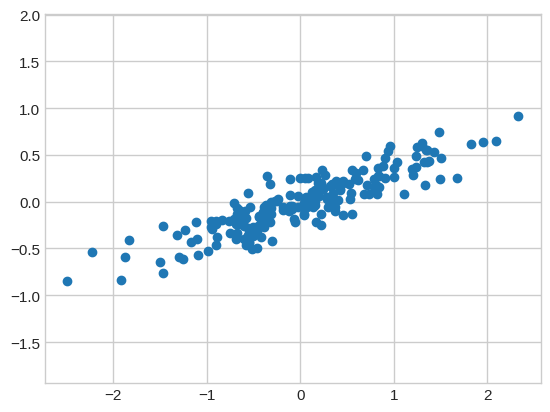

In [17]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2,2), rng.randn(2, 200)).T
plt.scatter(X[:,0], X[:,1])
plt.axis('equal');

Rather than attempting to predict the y values from the x values, the unsupervised learning problem attempts to learn about the relationship between the x and y values.

In principal component analysis, this relationship is quantified by finding a list of the principal axes in the data, and using those axes to describe the dataset. Using Scikit-Learn's PCA estimator, we can compute this as follows:

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [19]:
print(f'{pca.components_=}\n{pca.explained_variance_=}')

pca.components_=array([[-0.94446029, -0.32862557],
       [-0.32862557,  0.94446029]])
pca.explained_variance_=array([0.7625315, 0.0184779])


To see what these numbers mean, let's visualize them as vectors over the input data, using the components to define the direction of the vector and the explained variance to define the squared length of the vector (see the following figure):

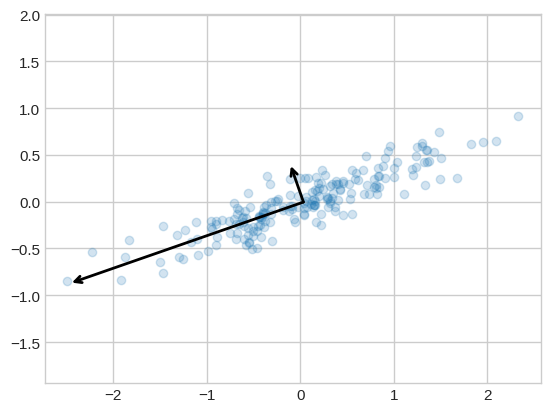

In [22]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->', linewidth=2,
                    shrinkA=0, shrinkB=0, color='black')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

This transformation from data axes to principal axes is an affine transformation, which basically means it is composed of a translation, rotation, and uniform scaling.

## PCA as dimensionality reduction

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

In [23]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


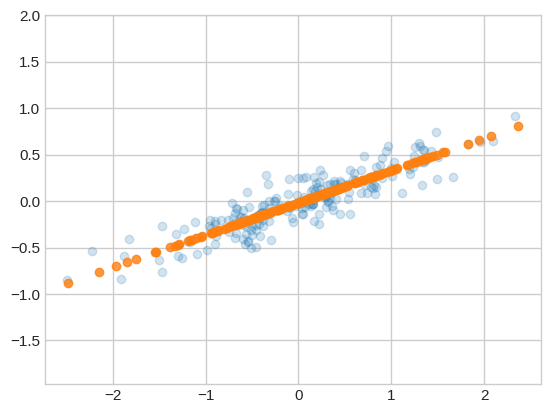

In [24]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

The light points are the original data, while the dark points are the projected version.
This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance.
The fraction of variance that is cut out (proportional to the spread of points about the line formed in the preceding figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the number of data features by 50%, the overall relationships between the data points are mostly preserved.

## PCA for Visualization: Handwritten Digits

In [25]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Recall that the digits dataset consists of 8 × 8–pixel images, meaning that they are 64-dimensional. To gain some intuition into the relationships between these points, we can use PCA to project them into a more manageable number of dimensions, say two:

In [26]:
pca = PCA(2)
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


/tmp/ipykernel_2853346/2943749715.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('rainbow', 10))


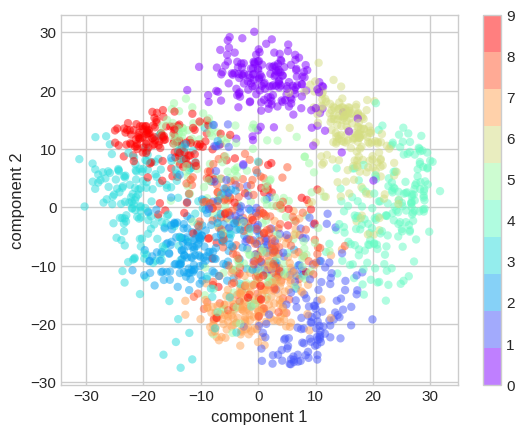

In [27]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('rainbow', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

### What Do the Components Mean?

We can go a bit further here, and begin to ask what the reduced dimensions *mean*.
This meaning can be understood in terms of combinations of basis vectors.
For example, each image in the training set is defined by a collection of 64 pixel values, which we will call the vector $x$:

$$
x = [x_1, x_2, x_3 \cdots x_{64}]
$$

One way we can think about this is in terms of a pixel basis.
That is, to construct the image, we multiply each element of the vector by the pixel it describes, and then add the results together to build the image:

$$
{\rm image}(x) = x_1 \cdot{\rm (pixel~1)} + x_2 \cdot{\rm (pixel~2)} + x_3 \cdot{\rm (pixel~3)} \cdots x_{64} \cdot{\rm (pixel~64)}
$$

One way we might imagine reducing the dimensionality of this data is to zero out all but a few of these basis vectors.
For example, if we use only the first eight pixels, we get an eight-dimensional projection of the data (the following figure). However, it is not very reflective of the whole image: we've thrown out nearly 90% of the pixels!

<img src='data/05.09-digits-pixel-components.png' />

The upper row of panels shows the individual pixels, and the lower row shows the cumulative contribution of these pixels to the construction of the image.
Using only eight of the pixel-basis components, we can only construct a small portion of the 64-pixel image.
Were we to continue this sequence and use all 64 pixels, we would recover the original image.

But the pixel-wise representation is not the only choice of basis. We can also use other basis functions, which each contain some predefined contribution from each pixel, and write something like:

$$
image(x) = {\rm mean} + x_1 \cdot{\rm (basis~1)} + x_2 \cdot{\rm (basis~2)} + x_3 \cdot{\rm (basis~3)} \cdots
$$

PCA can be thought of as a process of choosing optimal basis functions, such that adding together just the first few of them is enough to suitably reconstruct the bulk of the elements in the dataset.
The principal components, which act as the low-dimensional representation of our data, are simply the coefficients that multiply each of the elements in this series.
the following figure shows a similar depiction of reconstructing the same digit using the mean plus the first eight PCA basis functions.

<img src="data/05.09-digits-pca-components.png" />

Unlike the pixel basis, the PCA basis allows us to recover the salient features of the input image with just a mean, plus eight components!
The amount of each pixel in each component is the corollary of the orientation of the vector in our two-dimensional example.
This is the sense in which PCA provides a low-dimensional representation of the data: it discovers a set of basis functions that are more efficient than the native pixel basis of the input data.

### Choosing the Number of Components

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data.
This can be determined by looking at the cumulative *explained variance ratio* as a function of the number of components (see the following figure):

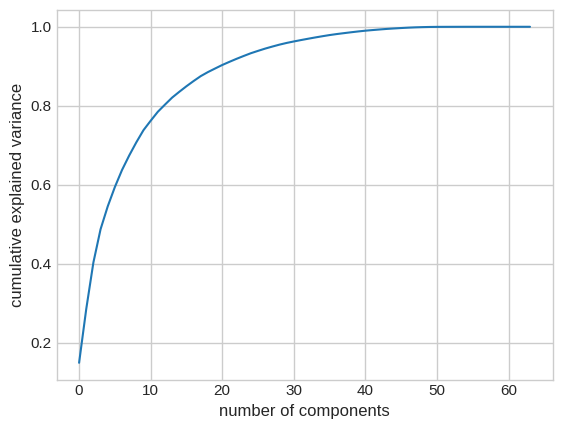

In [29]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## PCA as Noise Filtering

PCA can also be used as a filtering approach for noisy data.
The idea is this: any components with variance much larger than the effect of the noise should be relatively unaffected by the noise.
So, if you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and throwing out the noise.

Let's see how this looks with the digits data.
First we will plot several of the input noise-free input samples (the following figure):

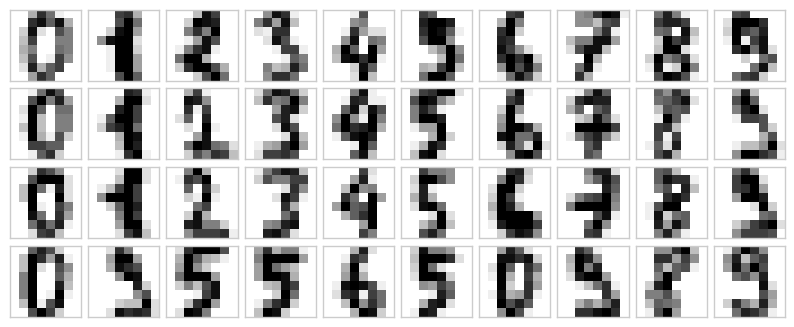

In [30]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4), 
                             subplot_kw={'xticks':[], 'yticks':[]}, 
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8,8), 
                  cmap='binary', interpolation='nearest', 
                  clim=(0, 16))

plot_digits(digits.data);

Now let's add some random noise to create a noisy dataset, and replot it (the following figure):

In [31]:
rng = np.random.default_rng(42)
rng.normal(10, 2)

10.609434159508863

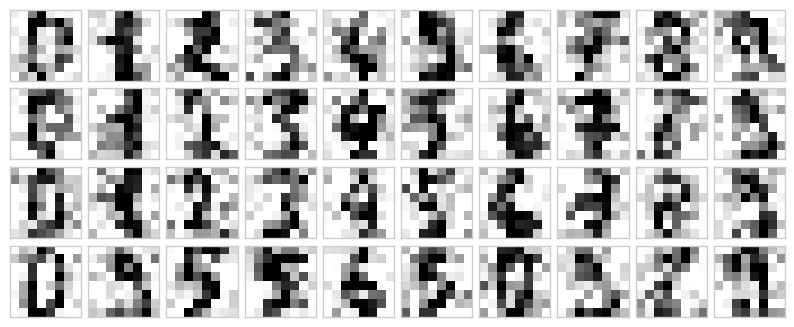

In [32]:
rng = np.random.default_rng(42)
noisy = rng.normal(digits.data, 4)
plot_digits(noisy);

The visualization makes the presence of this random noise clear.
Let's train a PCA model on the noisy data, requesting that the projection preserve 50% of the variance:

In [33]:
pca = PCA(0.5).fit(noisy)
pca.n_components_

12

Here 50% of the variance amounts to 12 principal components, out of the 64 original features.
Now we compute these components, and then use the inverse of the transform to reconstruct the filtered digits; the following figure shows the result:

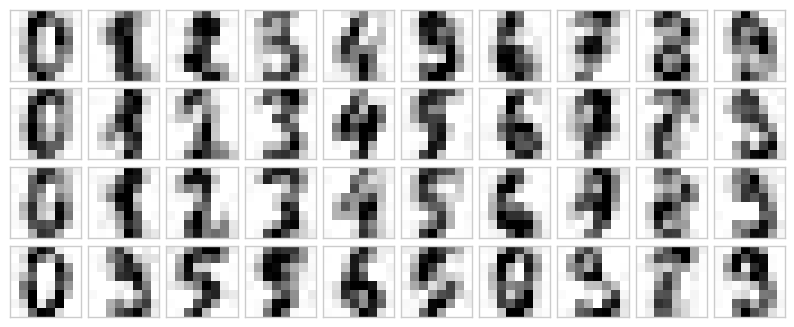

In [34]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

This signal preserving/noise filtering property makes PCA a very useful feature selection routine—for example, rather than training a classifier on very high-dimensional data, you might instead train the classifier on the lower-dimensional principal component representation, which will automatically serve to filter out random noise in the inputs.

# Example: Eigenfaces

In [35]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [37]:
dir(faces)

['DESCR', 'data', 'images', 'target', 'target_names']

Let's take a look at the principal axes that span this dataset.
Because this is a large dataset, we will use the `"random"` eigensolver in the `PCA` estimator: it uses a randomized method to approximate the first $N$ principal components more quickly than the standard approach, at the expense of some accuracy. This trade-off can be useful for high-dimensional data (here, a dimensionality of nearly 3,000).
We will take a look at the first 150 components:

In [38]:
pca = PCA(150, svd_solver='randomized', random_state=42)
pca.fit(faces.data)

PCA(n_components=150, random_state=42, svd_solver='randomized')

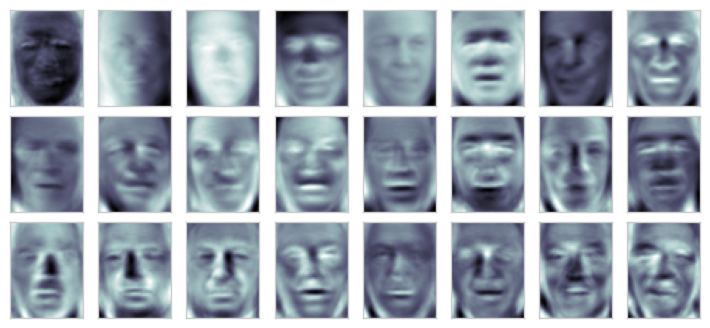

In [40]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

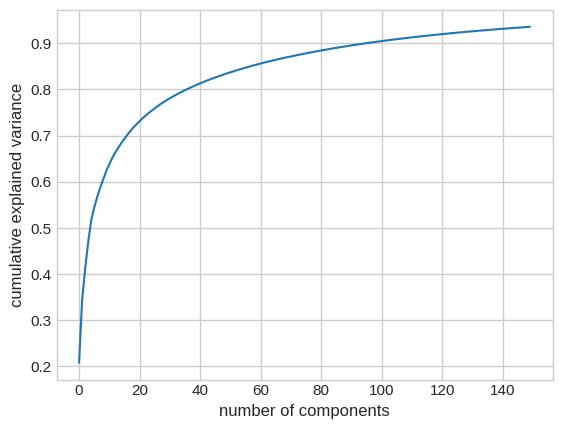

In [41]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

The 150 components we have chosen account for just over 90% of the variance.
That would lead us to believe that using these 150 components, we would recover most of the essential characteristics of the data.
To make this more concrete, we can compare the input images with the images reconstructed from these 150 components (see the following figure):

In [42]:
pca = pca.fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

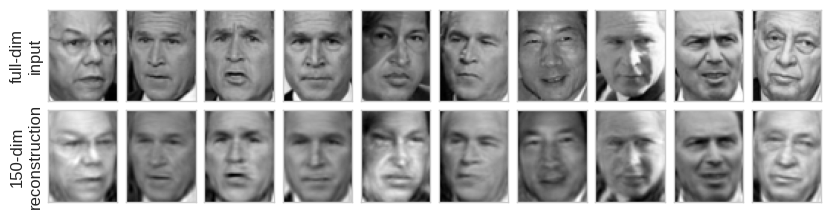

In [43]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

## Summary

In this chapter we explored the use of principal component analysis for dimensionality reduction, visualization of high-dimensional data, noise filtering, and feature selection within high-dimensional data.
Because of its versatility and interpretability, PCA has been shown to be effective in a wide variety of contexts and disciplines.
Given any high-dimensional dataset, I tend to start with PCA in order to visualize the relationships between points (as we did with the digits data), to understand the main variance in the data (as we did with the eigenfaces), and to understand the intrinsic dimensionality (by plotting the explained variance ratio).
Certainly PCA is not useful for every high-dimensional dataset, but it offers a straightforward and efficient path to gaining insight into high-dimensional data.

PCA's main weakness is that it tends to be highly affected by outliers in the data.
For this reason, several robust variants of PCA have been developed, many of which act to iteratively discard data points that are poorly described by the initial components.
Scikit-Learn includes a number of interesting variants on PCA in the `sklearn.decomposition` submodule; one example is `SparsePCA`, which introduces a regularization term (see [In Depth: Linear Regression](05.06-Linear-Regression.ipynb)) that serves to enforce sparsity of the components.

In the following chapters, we will look at other unsupervised learning methods that build on some of the ideas of PCA.